In [44]:
import tensorflow as tf
from IPython.core.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow .keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,TensorBoard,ModelCheckpoint
from sklearn.metrics import classification_report , confusion_matrix
import ipywidgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings


/tmp/ipykernel_6950/4006962970.py:2: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output


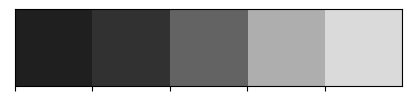

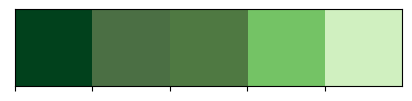

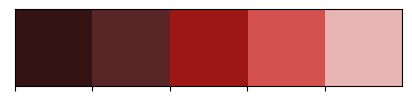

In [10]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [11]:
labels = ['glioma','notumor','meningioma','pituitary']

In [61]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/home/mo/Untitled Folder/data','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/home/mo/Untitled Folder/data', 'Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████████████████████████████████████████████| 300/300 [00:00<00:00, 607.09it/s]


In [62]:
X_train , y_train = shuffle(X_train , y_train , random_state = 101)

In [63]:
X_train.shape

(7023, 150, 150, 3)

In [64]:
X_train , X_test , y_train , y_test = train_test_split(X_train , y_train , test_size = 0.1 , random_state = 101)

In [65]:
y_train

array(['notumor', 'meningioma', 'pituitary', ..., 'pituitary', 'glioma',
       'glioma'], dtype='<U10')

In [66]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)


In [71]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

2022-10-26 17:12:38.085299: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-26 17:12:38.086039: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-26 17:12:38.086143: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mo-HP-EliteBook-850-G3): /proc/driver/nvidia/version does not exist
2022-10-26 17:12:38.087663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


16705208/16705208 [==============================] - 4s 0us/step


In [74]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate = 0.5)(model)
model = tf.keras.layers.Dense(4 , activation = 'softmax')(model)
model = tf.keras.models.Model(inputs = effnet.input , outputs = model)

In [77]:
model.compile(loss = 'categorical_crossentropy' , optimizer = 'Adam' , metrics = ['accuracy'])

In [78]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [79]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

2022-10-26 17:21:55.060822: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 383940000 exceeds 10% of free system memory.


Epoch 1/12


2022-10-26 17:22:04.822887: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 69120000 exceeds 10% of free system memory.
2022-10-26 17:22:04.853304: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 69120000 exceeds 10% of free system memory.
2022-10-26 17:22:04.943486: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 69120000 exceeds 10% of free system memory.
2022-10-26 17:22:05.007863: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 72855552 exceeds 10% of free system memory.


178/178 [==============================] - ETA: 0s - loss: 0.2573 - accuracy: 0.9079
Epoch 1: val_accuracy improved from -inf to 0.91930, saving model to effnet.h5


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

pred = model.predict(X_test)

In [82]:
pred = model.predict(X_test)

22/22 [==============================] - 14s 571ms/step


In [83]:
round(pred[:10])

array([[6.0871520e-07, 3.5060839e-09, 1.6284247e-07, 9.9999911e-01],
       [7.1366792e-08, 1.4471202e-07, 9.9999970e-01, 3.7237544e-09],
       [9.9999994e-01, 1.2410961e-09, 9.7569330e-09, 7.8037523e-09],
       [2.3933419e-10, 1.7170347e-13, 1.1979686e-12, 9.9999994e-01],
       [3.5912033e-09, 9.9999994e-01, 2.2457152e-09, 3.1206118e-11],
       [9.9999994e-01, 9.6123817e-11, 1.1674900e-10, 7.8072132e-11],
       [3.4814829e-03, 4.3917220e-04, 9.7315890e-01, 2.2920430e-02],
       [3.3139852e-07, 9.9999481e-01, 4.3351997e-06, 4.2775784e-07],
       [9.9999994e-01, 3.7699305e-08, 4.5319741e-08, 2.0561510e-09],
       [4.5106834e-05, 9.9988705e-01, 6.7742956e-05, 1.1520931e-07]],
      dtype=float32)

In [84]:
y_test[:10]

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)